In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sb

from pathlib import Path

from lola.plot import draw

os.environ["PATH"] += ":/mnt/sw/nix/store/80wb60hk9c9hbi1rzbnr6kdbbjknp4ch-texlive-20220321/bin/x86_64-linux"

outdir = Path("./figures")
outdir.mkdir(exist_ok=True)

rc = {
    "axes.axisbelow": True,
    "axes.linewidth": 1.0,
    "axes.labelsize": "x-small",
    "axes.titlesize": "x-small",
    "figure.dpi": 150,
    "figure.figsize": (3.2, 3.2),
    "font.size": 12.0,
    "legend.fontsize": "xx-small",
    "lines.linewidth": 1.0,
    "savefig.transparent": True,
    "xtick.labelsize": "xx-small",
    "xtick.major.width": 1.0,
    "ytick.labelsize": "xx-small",
    "ytick.major.width": 1.0,
    "font.family": ["serif"],
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts}",
}

plt.rcParams.update(rc)

## Dataframe

In [2]:
df = pd.read_csv(
    "~/ceph/lola/results/euler_all/stats.csv",
    names=[
        "run",
        "target",
        "compression",
        "method",
        "settings",
        "guidance",
        "context",
        "overlap",
        "speed",
        "split",
        "index",
        "start",
        "seed",
        "field",
        "time",
        "auto_encoded",
        "m1",
        "m2",
        "spread",
        "rmse",
        "nrmse",
        "vrmse",
        "re_total",
        "rmse_p_low",
        "rmse_c_low",
        "rmse_p_mid",
        "rmse_c_mid",
        "rmse_p_high",
        "rmse_c_high",
        "rmse_p_sub",
        "rmse_c_sub",
        "gamma",
        "bc00",
        "bc01",
        "bc10",
        "bc11",
    ],
    dtype={"settings": str, "guidance": str, "compression": int},
)

df = df[~df["auto_encoded"]]
df = df[df["time"] > 0]
df = df.sort_values(["method", "compression"], kind="stable")
df = df.merge(
    pd.DataFrame({
        "field": [0, 1, 2, 3, 4],
        "std_global": [0.55, 0.25, 0.30, 0.50, 0.50],
    })
)


def horizon(t):
    if t < 20:
        return "1:20"
    elif t < 60:
        return "21:60"
    else:
        return "61:100"


df["horizon"] = df["time"].apply(horizon)
df["std_instant"] = np.sqrt(df["m2"] - df["m1"] ** 2)
df["spread_skill"] = (df["spread"] + 1e-3) / (df["rmse"] + 1e-3)
df["method"] = df["method"].replace("surrogate", "neural solver")
df.loc[df["method"] == "neural solver", "spread_skill"] = 0.0

In [3]:
def aggregate(x):
    return np.mean(x)

### Plots

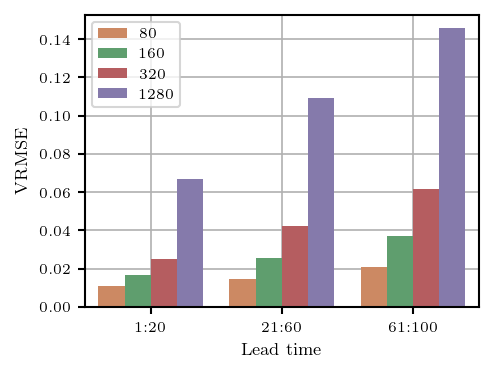

In [4]:
table = df[df["method"] == "autoencoder"]

fig = plt.figure(figsize=(3.2, 2.4))

ax = sb.barplot(
    table,
    x="horizon",
    y="vrmse",
    hue="compression",
    estimator=aggregate,
    errorbar=None,
    palette=sb.color_palette("deep", 5)[1:],
)

ax.grid()
ax.get_legend().set_title(None)

ax.set_xlabel("Lead time")
ax.set_ylabel("VRMSE")

fig.tight_layout(pad=0.33)

plt.savefig(outdir / "euler_ae.pdf", dpi=300, transparent=True)

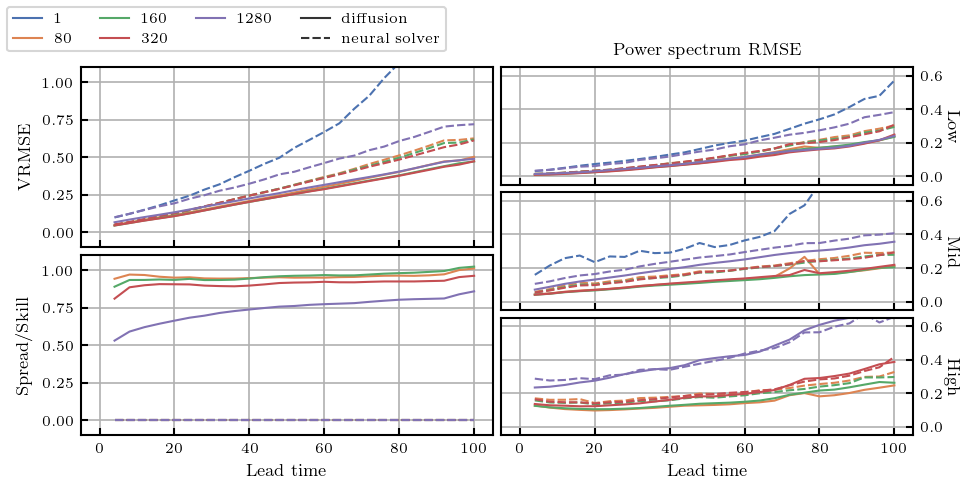

In [5]:
table = df[df["method"] != "autoencoder"]

fig, axs = plt.subplot_mosaic(
    [
        [0, 2],
        [0, 2],
        [0, 3],
        [1, 3],
        [1, 4],
        [1, 4],
    ],
    figsize=(6.4, 3.2),
    sharex=True,
    sharey=False,
)

for i, metric in enumerate(["VRMSE", "spread_skill"]):
    ax = sb.lineplot(
        table,
        x="time",
        y=metric.lower(),
        hue="compression",
        style="method",
        estimator=aggregate,
        errorbar=None,
        palette=sb.color_palette("deep", 5),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Lead time")
    ax.set_xlim(-5, 105)
    ax.set_ylim(-0.1, 1.1)

    if metric == "spread_skill":
        ax.set_ylabel("Spread/Skill")
    else:
        ax.set_ylabel(metric)

    ax.tick_params(direction="in")

    handles, labels = ax.get_legend_handles_labels()

for i, band in enumerate(["Low", "Mid", "High"], start=2):
    ax = sb.lineplot(
        table,
        x="time",
        y=f"rmse_p_{band.lower()}",
        hue="compression",
        style="method",
        estimator=aggregate,
        errorbar=None,
        palette=sb.color_palette("deep", 5),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Lead time")
    ax.set_xlim(-5, 105)

    ax.set_ylabel(band)
    ax.set_ylim(-0.05, 0.65)

    ax.tick_params(direction="in")

    ax.yaxis.set_label_position("right")
    ax.yaxis.label.set(rotation=-90, va="center")
    ax.yaxis.tick_right()

    if i == 2:
        ax.set_title("Power spectrum RMSE")

for i, label in reversed(list(enumerate(labels))):
    if label in ("compression", "method"):
        blank = handles.pop(i)
        labels.pop(i)

handles.insert(-2, blank)
labels.insert(-2, None)

fig.align_labels()
fig.tight_layout(pad=0.33)
fig.subplots_adjust(top=0.875)
fig.legend(handles, labels, loc="upper left", ncol=4)

plt.savefig(outdir / "euler_mosaic.pdf", dpi=300, transparent=True)

## Tables

In [6]:
table = df[["method", "compression", "horizon", "vrmse"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(index=["method", "compression"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon                     1:20  21:60 61:100
method        compression                     
autoencoder   80           0.011  0.015  0.021
              160          0.017  0.025  0.037
              320          0.025  0.042  0.062
              1280         0.067  0.109  0.146
diffusion     80           0.075  0.200  0.396
              160          0.071  0.192  0.374
              320          0.070  0.192  0.370
              1280         0.093  0.217  0.399
neural solver 1            0.138  0.397  1.102
              80           0.077  0.232  0.499
              160          0.077  0.232  0.487
              320          0.080  0.232  0.476
              1280         0.137  0.314  0.592

In [7]:
table = df[(df["method"] != "autoencoder") & (df["compression"] > 1)]
table = table[["method", "context", "horizon", "vrmse"]]

table = table.groupby(["method", "context", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(index=["method", "context"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon                 1:20  21:60 61:100
method        context                     
diffusion     1        0.083  0.203  0.390
              2        0.073  0.198  0.382
              3        0.075  0.200  0.382
neural solver 1        0.102  0.260  0.517
              2        0.088  0.246  0.502
              3        0.089  0.253  0.521

In [8]:
table = df[["method", "compression", "horizon", "rmse_p_low", "rmse_p_mid", "rmse_p_high"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(
    index=["method", "compression"],
    columns="horizon",
    values=["rmse_p_low", "rmse_p_mid", "rmse_p_high"],
)
# print(table.to_latex(float_format="%.3f"))
table

rmse_p_low               rmse_p_mid                \
horizon                         1:20  21:60 61:100       1:20  21:60 61:100   
method        compression                                                     
autoencoder   80               0.001  0.001  0.001      0.006  0.008  0.014   
              160              0.001  0.001  0.002      0.012  0.022  0.040   
              320              0.002  0.003  0.004      0.024  0.048  0.086   
              1280             0.010  0.017  0.025      0.087  0.171  0.267   
diffusion     80               0.017  0.063  0.168      0.054  0.100  0.178   
              160              0.015  0.060  0.165      0.051  0.096  0.160   
              320              0.014  0.058  0.157      0.052  0.102  0.172   
              1280             0.019  0.065  0.164      0.096  0.187  0.300   
neural solver 1                0.046  0.129  0.339      0.227  0.298  0.755   
              80               0.021  0.074  0.210      0.086  0.151  0.246   
              160              0.021  0.074  0.204      0.077  0.144  0.236   
              320              0.020  0.075  0.203      0.075  0.145  0.236   
              1280             0.045  0.116  0.275      0.131  0.227  0.349   

                          rmse_p_high                
horizon                          1:20  21:60 61:100  
method        compression                            
autoencoder   80                0.069  0.070  0.100  
              160               0.089  0.099  0.160  
              320               0.111  0.142  0.249  
              1280              0.237  0.364  0.596  
diffusion     80                0.112  0.116  0.186  
              160               0.115  0.123  0.206  
              320               0.128  0.156  0.279  
              1280              0.246  0.350  0.571  
neural solver 1                 0.821  0.983  2.662  
              80                0.164  0.174  0.252  
              160               0.147  0.158  0.237  
              320               0.151  0.170  0.274  
              1280              0.283  0.346  0.550

## Images

In [9]:
path = Path("~/ceph/lola/videos/euler_all")

runs = df[["run", "method", "compression"]]
runs = runs.drop_duplicates()

field = 1
frames = np.array([5, 15, 25])

for run, method, compression in runs.values:
    files = (path / run).glob("*.npz")
    files = sorted(files)

    for i, file in enumerate(files):
        x, x_hat = np.load(file).values()

        x = x[field, frames, ::2, ::2]
        x_hat = x_hat[:, field, frames, ::2, ::2]

        vmin = np.nanquantile(x, 0.01, keepdims=True) - 1e-2
        vmax = np.nanquantile(x, 0.99, keepdims=True) + 1e-2

        draw(x, vmin=vmin, vmax=vmax, pad=8).save(outdir / f"euler_{i}_gt.png")

        for j in range(len(x_hat)):
            draw(x_hat[j], vmin=vmin, vmax=vmax, pad=8).save(outdir / f"euler_{i}_{method}_{compression:04d}_{j}.png")